In [39]:
# %% [code]
# ============================================================================
# COMPLETE CANADA DATA LOADER WITH SECTORAL ANALYSIS
# ============================================================================

import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("CANADA ECONOMIC DATA LOADER WITH SECTORAL ANALYSIS")
print("="*70)

# Set data directory
DATA_DIR = "../data/raw"
print(f"Looking for data in: {DATA_DIR}")

# %% [code]
# 1. LOAD OIL DATA
print("\n" + "="*70)
print("1. LOADING OIL PRICE DATA")
print("="*70)

oil_path = os.path.join(DATA_DIR, "wti_crude_prices_2010_2024.csv")
if os.path.exists(oil_path):
    try:
        oil_data = pd.read_csv(oil_path)
        oil_data['date'] = pd.to_datetime(oil_data['date'])
        oil_data.set_index('date', inplace=True)
        print(f"✓ Oil data loaded: {len(oil_data)} rows")
        print(f"  Date range: {oil_data.index.min().date()} to {oil_data.index.max().date()}")
        print(f"  Price range: ${oil_data['price'].min():.2f} to ${oil_data['price'].max():.2f}")
    except Exception as e:
        print(f"✗ Error loading oil data: {e}")
        oil_data = None
else:
    print(f"✗ Oil data file not found: {oil_path}")
    oil_data = None

# %% [code]
# 2. LOAD AND PROCESS SECTORAL EMPLOYMENT DATA
print("\n" + "="*70)
print("2. LOADING SECTORAL EMPLOYMENT DATA")
print("="*70)

emp_sector_path = os.path.join(DATA_DIR, "canada_employment.csv")
if os.path.exists(emp_sector_path):
    try:
        # Read the sectoral employment data (skip first 6 rows of metadata)
        sector_emp_raw = pd.read_csv(emp_sector_path, encoding='utf-8', skiprows=6)
        
        print(f"✓ Sectoral employment data loaded: {len(sector_emp_raw)} rows, {len(sector_emp_raw.columns)} columns")
        
        # Find the industry column (first column with industry names)
        industry_col = sector_emp_raw.columns[0]
        
        # Get list of all industries (exclude total rows and metadata rows)
        all_industries = []
        industry_data = {}
        
        for idx, row in sector_emp_raw.iterrows():
            industry_name = str(row[industry_col]) if not pd.isna(row[industry_col]) else ""
            
            # Skip metadata rows and totals
            if not industry_name or any(x in industry_name for x in ['Geography', 'Type of employee', 'North American', 'Persons', 'Symbol legend']):
                continue
            
            # Skip footnote and citation rows
            if industry_name.startswith('Footnotes') or industry_name.startswith('How to cite'):
                continue
            
            # Process each industry's time series
            time_series = {}
            for col_name, value in row.items():
                # Skip industry name column and empty columns
                if col_name == industry_col or pd.isna(col_name):
                    continue
                
                # Parse date from column name (e.g., "January 2010")
                try:
                    # Clean column name
                    col_clean = str(col_name).strip()
                    if col_clean.startswith('"') and col_clean.endswith('"'):
                        col_clean = col_clean[1:-1]
                    
                    # Parse date
                    try:
                        date = pd.to_datetime(col_clean)
                    except:
                        # Try alternative format
                        date = pd.to_datetime(col_clean, format='%B %Y')
                    
                    # Clean employment value (remove quality flags A, B, C)
                    if not pd.isna(value):
                        val_str = str(value)
                        # Remove quality flags and commas
                        for flag in ['A', 'B', 'C', 'D', 'E', 'F']:
                            val_str = val_str.replace(flag, '')
                        val_str = val_str.replace(',', '').strip()
                        
                        if val_str and val_str != 'nan':
                            try:
                                time_series[date] = float(val_str)
                            except:
                                pass
                except Exception as e:
                    continue
            
            # Only add if we have time series data
            if time_series:
                all_industries.append(industry_name)
                industry_data[industry_name] = time_series
        
        # Convert to DataFrame
        sector_emp_df = pd.DataFrame(industry_data)
        sector_emp_df.index = pd.to_datetime(sector_emp_df.index)
        sector_emp_df = sector_emp_df.sort_index()
        
        # Select key sectors for analysis (you can modify this list)
        key_sectors = [
        'Goods producing industries 9',
        'Forestry, logging and support 10',
        'Mining, quarrying, and oil and gas extraction',
        'Utilities',
        'Construction',
        'Manufacturing',
        'Service producing industries 11',
        'Trade 12',
        'Transportation and warehousing',
        'Information and cultural industries',
        'Finance and insurance',
        'Real estate and rental and leasing',
        'Professional, scientific and technical services',
        'Management of companies and enterprises',
        'Administrative and support, waste management and remediation services',
        'Educational services',
        'Health care and social assistance',
        'Arts, entertainment and recreation',
        'Accommodation and food services',
        'Other services (except public administration)',
        'Public administration',
        'Unclassified businesses 7'
        ]
        
        # Filter to key sectors
        available_sectors = [s for s in key_sectors if s in sector_emp_df.columns]
        sector_emp_df = sector_emp_df[available_sectors]
        
        print(f"✓ Processed {len(sector_emp_df.columns)} key sectors")
        print(f"  Available sectors: {list(sector_emp_df.columns)}")
        print(f"  Date range: {sector_emp_df.index.min().date()} to {sector_emp_df.index.max().date()}")
        print(f"  Data frequency: Monthly")
        
    except Exception as e:
        print(f"✗ Error loading sectoral employment data: {e}")
        import traceback
        traceback.print_exc()
        sector_emp_df = None
else:
    print(f"✗ Sectoral employment file not found")
    sector_emp_df = None

# %% [code]
# 3. LOAD GDP DATA
print("\n" + "="*70)
print("3. LOADING GDP DATA")
print("="*70)

gdp_path = os.path.join(DATA_DIR, "canada_gdp.csv")
if os.path.exists(gdp_path):
    try:
        # Read GDP data (skip first 6 rows)
        gdp_raw = pd.read_csv(gdp_path, encoding='utf-8', skiprows=6)
        
        print(f"✓ GDP data loaded: {len(gdp_raw)} rows, {len(gdp_raw.columns)} columns")
        
        # Find the industry column
        industry_col = gdp_raw.columns[0]
        
        # Extract time series for key sectors
        gdp_data = {}
        
        # Define sectors we want from GDP data
        gdp_sectors_of_interest = [
        'Goods producing industries 9',
        'Forestry, logging and support 10',
        'Mining, quarrying, and oil and gas extraction',
        'Utilities',
        'Construction',
        'Manufacturing',
        'Service producing industries 11',
        'Trade 12',
        'Transportation and warehousing',
        'Information and cultural industries',
        'Finance and insurance',
        'Real estate and rental and leasing',
        'Professional, scientific and technical services',
        'Management of companies and enterprises',
        'Administrative and support, waste management and remediation services',
        'Educational services',
        'Health care and social assistance',
        'Arts, entertainment and recreation',
        'Accommodation and food services',
        'Other services (except public administration)',
        'Public administration',
        'Unclassified businesses 7'
        ]
        
        for gdp_sector in gdp_sectors_of_interest:
            # Find the row for this sector
            sector_row = gdp_raw[gdp_raw[industry_col].str.contains(gdp_sector.split('[')[0].strip(), na=False)]
            
            if len(sector_row) > 0:
                row = sector_row.iloc[0]
                time_series = {}
                
                for col_name, value in row.items():
                    if col_name == industry_col or pd.isna(col_name):
                        continue
                    
                    # Parse quarter (e.g., "Q1 2010")
                    try:
                        col_clean = str(col_name).strip()
                        if col_clean.startswith('"') and col_clean.endswith('"'):
                            col_clean = col_clean[1:-1]
                        
                        if col_clean.startswith('Q'):
                            quarter, year = col_clean.split()
                            quarter_num = int(quarter[1])
                            month = (quarter_num - 1) * 3 + 1
                            date = pd.to_datetime(f"{year}-{month:02d}-01")
                            
                            if not pd.isna(value):
                                try:
                                    # Convert to float (remove commas if present)
                                    val_str = str(value).replace(',', '').strip()
                                    time_series[date] = float(val_str)
                                except:
                                    pass
                    except:
                        continue
                
                if time_series:
                    sector_name = gdp_sector.split('[')[0].strip()
                    gdp_data[sector_name] = time_series
        
        # Convert to DataFrame
        gdp_df = pd.DataFrame(gdp_data)
        gdp_df.index = pd.to_datetime(gdp_df.index)
        gdp_df = gdp_df.sort_index()
        
        print(f"✓ Processed GDP data for {len(gdp_df.columns)} sectors")
        print(f"  Available GDP sectors: {list(gdp_df.columns)}")
        print(f"  Date range: {gdp_df.index.min().date()} to {gdp_df.index.max().date()}")
        print(f"  Data frequency: Quarterly")
        
    except Exception as e:
        print(f"✗ Error loading GDP data: {e}")
        import traceback
        traceback.print_exc()
        gdp_df = None
else:
    print(f"✗ GDP file not found")
    gdp_df = None


CANADA ECONOMIC DATA LOADER WITH SECTORAL ANALYSIS
Looking for data in: ../data/raw

1. LOADING OIL PRICE DATA
✓ Oil data loaded: 3771 rows
  Date range: 2010-01-04 to 2024-12-30
  Price range: $-37.63 to $123.70

2. LOADING SECTORAL EMPLOYMENT DATA
✓ Sectoral employment data loaded: 47 rows, 1 columns
✓ Processed 0 key sectors
  Available sectors: []
  Date range: NaT to NaT
  Data frequency: Monthly

3. LOADING GDP DATA
✓ GDP data loaded: 47 rows, 1 columns
✓ Processed GDP data for 0 sectors
  Available GDP sectors: []
  Date range: NaT to NaT
  Data frequency: Quarterly


In [17]:
# %% [code]
# ============================================================================
# FIXED EMPLOYMENT DATA LOADER - PROPERLY TRANSFORMED
# ============================================================================

import pandas as pd
import numpy as np
import os
from datetime import datetime

print("="*70)
print("FIXED EMPLOYMENT DATA LOADER")
print("="*70)

# Load the employment data correctly
emp_path = os.path.join("../data/raw", "canada_employment.csv")

# Read with skiprows=10 (this works based on debug)
emp_raw = pd.read_csv(emp_path, encoding='utf-8', skiprows=10)

print(f"Raw data shape: {emp_raw.shape}")
print(f"First column name: '{emp_raw.columns[0]}'")

# The data has industries as rows, dates as columns
# Column 0 = Industry names
# Columns 1+ = Monthly data (January 2010, February 2010, etc.)

# Clean the industry names column
industry_col = emp_raw.columns[0]
emp_raw[industry_col] = emp_raw[industry_col].astype(str)

# Remove the first row which is just "Persons"
emp_clean = emp_raw[~emp_raw[industry_col].str.contains('Persons', na=False)].copy()

print(f"\nAfter removing 'Persons' row: {emp_clean.shape}")

# Transpose the data: industries become columns, dates become rows
print("\nTransposing data...")

# Extract industry names (they will become our column names)
industry_names = emp_clean[industry_col].tolist()
print(f"Found {len(industry_names)} industries")
print(f"Sample industries: {industry_names[:5]}")

# Extract date columns (they will become our index)
date_columns = emp_clean.columns[1:]  # Skip the industry name column
print(f"Found {len(date_columns)} date columns")
print(f"First 5 dates: {date_columns[:5].tolist()}")

# Create a new DataFrame with dates as index
transposed_data = {}

for idx, industry in enumerate(industry_names):
    # Get the row for this industry
    industry_row = emp_clean.iloc[idx]
    
    # Create time series for this industry
    time_series = {}
    
    for date_col in date_columns:
        value = industry_row[date_col]
        
        # Skip NaN values
        if pd.isna(value):
            continue
            
        # Parse the date from column name
        try:
            # Column names are like "January 2010", "February 2010", etc.
            date_str = str(date_col).strip()
            if date_str.startswith('"') and date_str.endswith('"'):
                date_str = date_str[1:-1]
            
            # Parse the date (first day of month)
            date = pd.to_datetime(date_str)
            
            # Clean the value (remove commas and quality flags A, B, C)
            val_str = str(value)
            for flag in ['A', 'B', 'C', 'D', 'E', 'F']:
                val_str = val_str.replace(flag, '')
            val_str = val_str.replace(',', '').strip()
            
            if val_str and val_str != 'nan':
                try:
                    time_series[date] = float(val_str)
                except:
                    pass
                    
        except Exception as e:
            # Skip if we can't parse this date
            continue
    
    if time_series:  # Only add if we have data
        # Clean industry name (remove footnotes like "6 7 8")
        clean_industry = industry.split('  [')[0].split('  (')[0].strip()
        transposed_data[clean_industry] = time_series

# Create the transposed DataFrame
emp_df = pd.DataFrame(transposed_data)
emp_df.index = pd.to_datetime(emp_df.index)
emp_df = emp_df.sort_index()

print(f"\n✓ Successfully transposed data!")
print(f"Final shape: {emp_df.shape}")
print(f"Date range: {emp_df.index.min().date()} to {emp_df.index.max().date()}")
print(f"Industries: {list(emp_df.columns)}")

# Save for debugging
os.makedirs('../data/processed', exist_ok=True)
emp_df.to_csv('../data/processed/employment_by_industry_transposed.csv')
print(f"\n✅ Saved transposed data to: ../data/processed/employment_by_industry_transposed.csv")


FIXED EMPLOYMENT DATA LOADER
Raw data shape: (44, 181)
First column name: 'North American Industry Classification System (NAICS) 4'

After removing 'Persons' row: (44, 181)

Transposing data...
Found 44 industries
Sample industries: ['nan', 'Industrial aggregate including unclassified businesses 6 7 8', 'Industrial aggregate excluding unclassified businesses 6 7 8', 'Goods producing industries 9', 'Forestry, logging and support 10']
Found 180 date columns
First 5 dates: ['January 2010', 'February 2010', 'March 2010', 'April 2010', 'May 2010']

✓ Successfully transposed data!
Final shape: (180, 24)
Date range: 2010-01-01 to 2024-12-01
Industries: ['Industrial aggregate including unclassified businesses 6 7 8', 'Industrial aggregate excluding unclassified businesses 6 7 8', 'Goods producing industries 9', 'Forestry, logging and support 10', 'Mining, quarrying, and oil and gas extraction', 'Utilities', 'Construction', 'Manufacturing', 'Service producing industries 11', 'Trade 12', 'Transp

In [40]:
# %% [code]
# ============================================================================
# STEP 2: ALIGN WITH OIL DATA
# ============================================================================

print("\n" + "="*70)
print("ALIGNING WITH OIL DATA")
print("="*70)

# Load oil data
oil_path = os.path.join("../data/raw", "wti_crude_prices_2010_2024.csv")
oil_data = pd.read_csv(oil_path)
oil_data['date'] = pd.to_datetime(oil_data['date'])
oil_data.set_index('date', inplace=True)

print(f"Oil data: {oil_data.shape[0]} days, {oil_data.shape[1]} columns")
print(f"Oil date range: {oil_data.index.min().date()} to {oil_data.index.max().date()}")

# Convert oil to monthly (end of month)
oil_monthly = oil_data['price'].resample('ME').last()  # ME = Month End
oil_monthly.name = 'oil_price'

print(f"\nOil monthly: {len(oil_monthly)} months")
print(f"Oil monthly range: {oil_monthly.index.min().date()} to {oil_monthly.index.max().date()}")

# Align employment data index to month end (to match oil data)
emp_df_month_end = emp_df.copy()
emp_df_month_end.index = emp_df_month_end.index + pd.offsets.MonthEnd(0)

print(f"\nEmployment data: {emp_df_month_end.shape[0]} months, {emp_df_month_end.shape[1]} industries")
print(f"Employment range: {emp_df_month_end.index.min().date()} to {emp_df_month_end.index.max().date()}")

# Find common dates
common_dates = oil_monthly.index.intersection(emp_df_month_end.index)
print(f"\n✓ Common dates: {len(common_dates)} months")
print(f"  From: {common_dates.min().date()}")
print(f"  To: {common_dates.max().date()}")

if len(common_dates) > 0:
    # Align both datasets
    oil_aligned = oil_monthly.loc[common_dates]
    emp_aligned = emp_df_month_end.loc[common_dates]
    
    print(f"\nAligned datasets:")
    print(f"  - Oil prices: {len(oil_aligned)} months")
    print(f"  - Employment: {len(emp_aligned)} months, {emp_aligned.shape[1]} industries")
    
    # Calculate monthly growth rates
    oil_growth = oil_aligned.pct_change() * 100
    oil_growth.name = 'oil_growth'
    
    emp_growth = emp_aligned.pct_change() * 100
    
    print(f"\nGrowth rates calculated (first row removed due to NaN)")
    print(f"  - Oil growth: {len(oil_growth.dropna())} months")
    
    # Create a combined DataFrame for analysis
    combined_df = pd.DataFrame({
        'oil_price': oil_aligned,
        'oil_growth': oil_growth
    })
    
        # Add employment growth for ALL sectors
    all_sectors = [
        'Goods producing industries 9',
        'Forestry, logging and support 10',
        'Mining, quarrying, and oil and gas extraction',
        'Utilities',
        'Construction',
        'Manufacturing',
        'Service producing industries 11',
        'Trade 12',
        'Transportation and warehousing',
        'Information and cultural industries',
        'Finance and insurance',
        'Real estate and rental and leasing',
        'Professional, scientific and technical services',
        'Management of companies and enterprises',
        'Administrative and support, waste management and remediation services',
        'Educational services',
        'Health care and social assistance',
        'Arts, entertainment and recreation',
        'Accommodation and food services',
        'Other services (except public administration)',
        'Public administration',
        'Unclassified businesses 7'
    ]
    
    for sector in all_sectors:
        if sector in emp_growth.columns:
            combined_df[f'{sector}_growth'] = emp_growth[sector]
            print(f"  - Added: {sector}")
    
    # Remove first row (NaN due to pct_change)
    combined_clean = combined_df.iloc[1:].dropna()
    
    print(f"\n✅ Final aligned dataset: {combined_clean.shape[0]} months, {combined_clean.shape[1]} variables")
    print("\nFirst few rows:")
    print(combined_clean.head())
    
    # Save aligned data
    combined_clean.to_csv('../data/processed/aligned_oil_employment_growth.csv')
    print(f"\n✅ Saved aligned data to: ../data/processed/aligned_oil_employment_growth.csv")
    
else:
    print("✗ No common dates found! Check date ranges.")


ALIGNING WITH OIL DATA
Oil data: 3771 days, 1 columns
Oil date range: 2010-01-04 to 2024-12-30

Oil monthly: 180 months
Oil monthly range: 2010-01-31 to 2024-12-31

Employment data: 180 months, 24 industries
Employment range: 2010-01-31 to 2024-12-31

✓ Common dates: 180 months
  From: 2010-01-31
  To: 2024-12-31

Aligned datasets:
  - Oil prices: 180 months
  - Employment: 180 months, 24 industries

Growth rates calculated (first row removed due to NaN)
  - Oil growth: 179 months
  - Added: Goods producing industries 9
  - Added: Forestry, logging and support 10
  - Added: Mining, quarrying, and oil and gas extraction
  - Added: Utilities
  - Added: Construction
  - Added: Manufacturing
  - Added: Service producing industries 11
  - Added: Trade 12
  - Added: Transportation and warehousing
  - Added: Information and cultural industries
  - Added: Finance and insurance
  - Added: Real estate and rental and leasing
  - Added: Professional, scientific and technical services
  - Added: M

In [19]:
# %% [code]
# ============================================================================
# STEP 3: FULL SECTOR CORRELATION ANALYSIS
# ============================================================================

if 'combined_clean' in locals() and len(combined_clean) > 0:
    print("\n" + "="*70)
    print("FULL SECTOR CORRELATION ANALYSIS")
    print("="*70)
    
    # Check correlations with oil growth
    oil_growth_col = combined_clean['oil_growth']
    
    correlations = []
    all_sectors = [
        'Goods producing industries 9',
        'Forestry, logging and support 10',
        'Mining, quarrying, and oil and gas extraction',
        'Utilities',
        'Construction',
        'Manufacturing',
        'Service producing industries 11',
        'Trade 12',
        'Transportation and warehousing',
        'Information and cultural industries',
        'Finance and insurance',
        'Real estate and rental and leasing',
        'Professional, scientific and technical services',
        'Management of companies and enterprises',
        'Administrative and support, waste management and remediation services',
        'Educational services',
        'Health care and social assistance',
        'Arts, entertainment and recreation',
        'Accommodation and food services',
        'Other services (except public administration)',
        'Public administration',
    ]
    
    for sector in all_sectors:
        sector_growth_col = f"{sector}_growth"
        
        if sector_growth_col in combined_clean.columns:
            sector_growth = combined_clean[sector_growth_col]
            
            # Calculate correlations at different lags (0-3 months)
            corr_0 = oil_growth_col.corr(sector_growth)
            corr_1 = oil_growth_col.shift(1).corr(sector_growth)
            corr_2 = oil_growth_col.shift(2).corr(sector_growth)
            corr_3 = oil_growth_col.shift(3).corr(sector_growth)
            
            # Find best lag
            corrs = [corr_0, corr_1, corr_2, corr_3]
            best_lag = np.argmax([abs(c) if not pd.isna(c) else -1 for c in corrs])
            best_corr = corrs[best_lag]
            
            correlations.append({
                'Sector': sector,
                'Correlation (0-month)': corr_0,
                'Correlation (1-month)': corr_1,
                'Correlation (2-month)': corr_2,
                'Correlation (3-month)': corr_3,
                'Best Lag': best_lag,
                'Best Correlation': best_corr
            })
    
    # Create results DataFrame
    results_df = pd.DataFrame(correlations)
    results_df['Abs Correlation'] = results_df['Best Correlation'].abs()
    results_df = results_df.sort_values('Abs Correlation', ascending=False)
    
    print("\n📊 FULL SECTOR SENSITIVITY TO OIL PRICES (Growth Rates):")
    print(results_df[['Sector', 'Best Correlation', 'Best Lag']].to_string(index=False))
    
    # Create short names for better display
    sector_name_shortener = {
        "Goods producing industries 9": "Goods Producing",
        "Forestry, logging and support 10": "Forestry & Logging",
        "Mining, quarrying, and oil and gas extraction": "Mining & Oil/Gas",
        "Service producing industries 11": "Service Producing",
        "Trade 12": "Trade",
        "Transportation and warehousing": "Transportation",
        "Information and cultural industries": "Information & Cultural",
        "Finance and insurance": "Finance & Insurance",
        "Real estate and rental and leasing": "Real Estate",
        "Professional, scientific and technical services": "Professional Services",
        "Management of companies and enterprises": "Management",
        "Administrative and support, waste management and remediation services": "Admin & Support",
        "Educational services": "Education",
        "Health care and social assistance": "Healthcare",
        "Arts, entertainment and recreation": "Arts & Entertainment",
        "Accommodation and food services": "Accommodation & Food",
        "Other services (except public administration)": "Other Services",
        "Public administration": "Public Admin",
    }
    
    results_df['Sector_Short'] = results_df['Sector'].map(lambda x: sector_name_shortener.get(x, x[:30]))
    
    print("\n📊 TOP 10 MOST SENSITIVE SECTORS:")
    top_10 = results_df.head(10)
    print(top_10[['Sector_Short', 'Best Correlation', 'Best Lag']].to_string(index=False))
    
    print("\n📊 TOP 10 LEAST SENSITIVE SECTORS:")
    bottom_10 = results_df.tail(10)
    print(bottom_10[['Sector_Short', 'Best Correlation', 'Best Lag']].to_string(index=False))
    
    # Save results
    results_df.to_csv('../data/processed/full_sector_correlations.csv', index=False)
    print(f"\n✅ Saved full correlation results to: ../data/processed/full_sector_correlations.csv")


FULL SECTOR CORRELATION ANALYSIS

📊 FULL SECTOR SENSITIVITY TO OIL PRICES (Growth Rates):
                                                               Sector  Best Correlation  Best Lag
                                      Accommodation and food services          0.526592         1
                        Other services (except public administration)          0.505882         1
                                    Health care and social assistance          0.447638         1
                                                        Manufacturing          0.433799         1
                                                             Trade 12          0.422966         1
                                   Arts, entertainment and recreation          0.393146         1
                                  Information and cultural industries          0.378037         2
                                         Goods producing industries 9          0.353296         1
                           


CREATING SINGLE-PAGE VISUALIZATION DASHBOARD
✅ Created single-page dashboard: outputs/plots/sector_sensitivity_dashboard.png


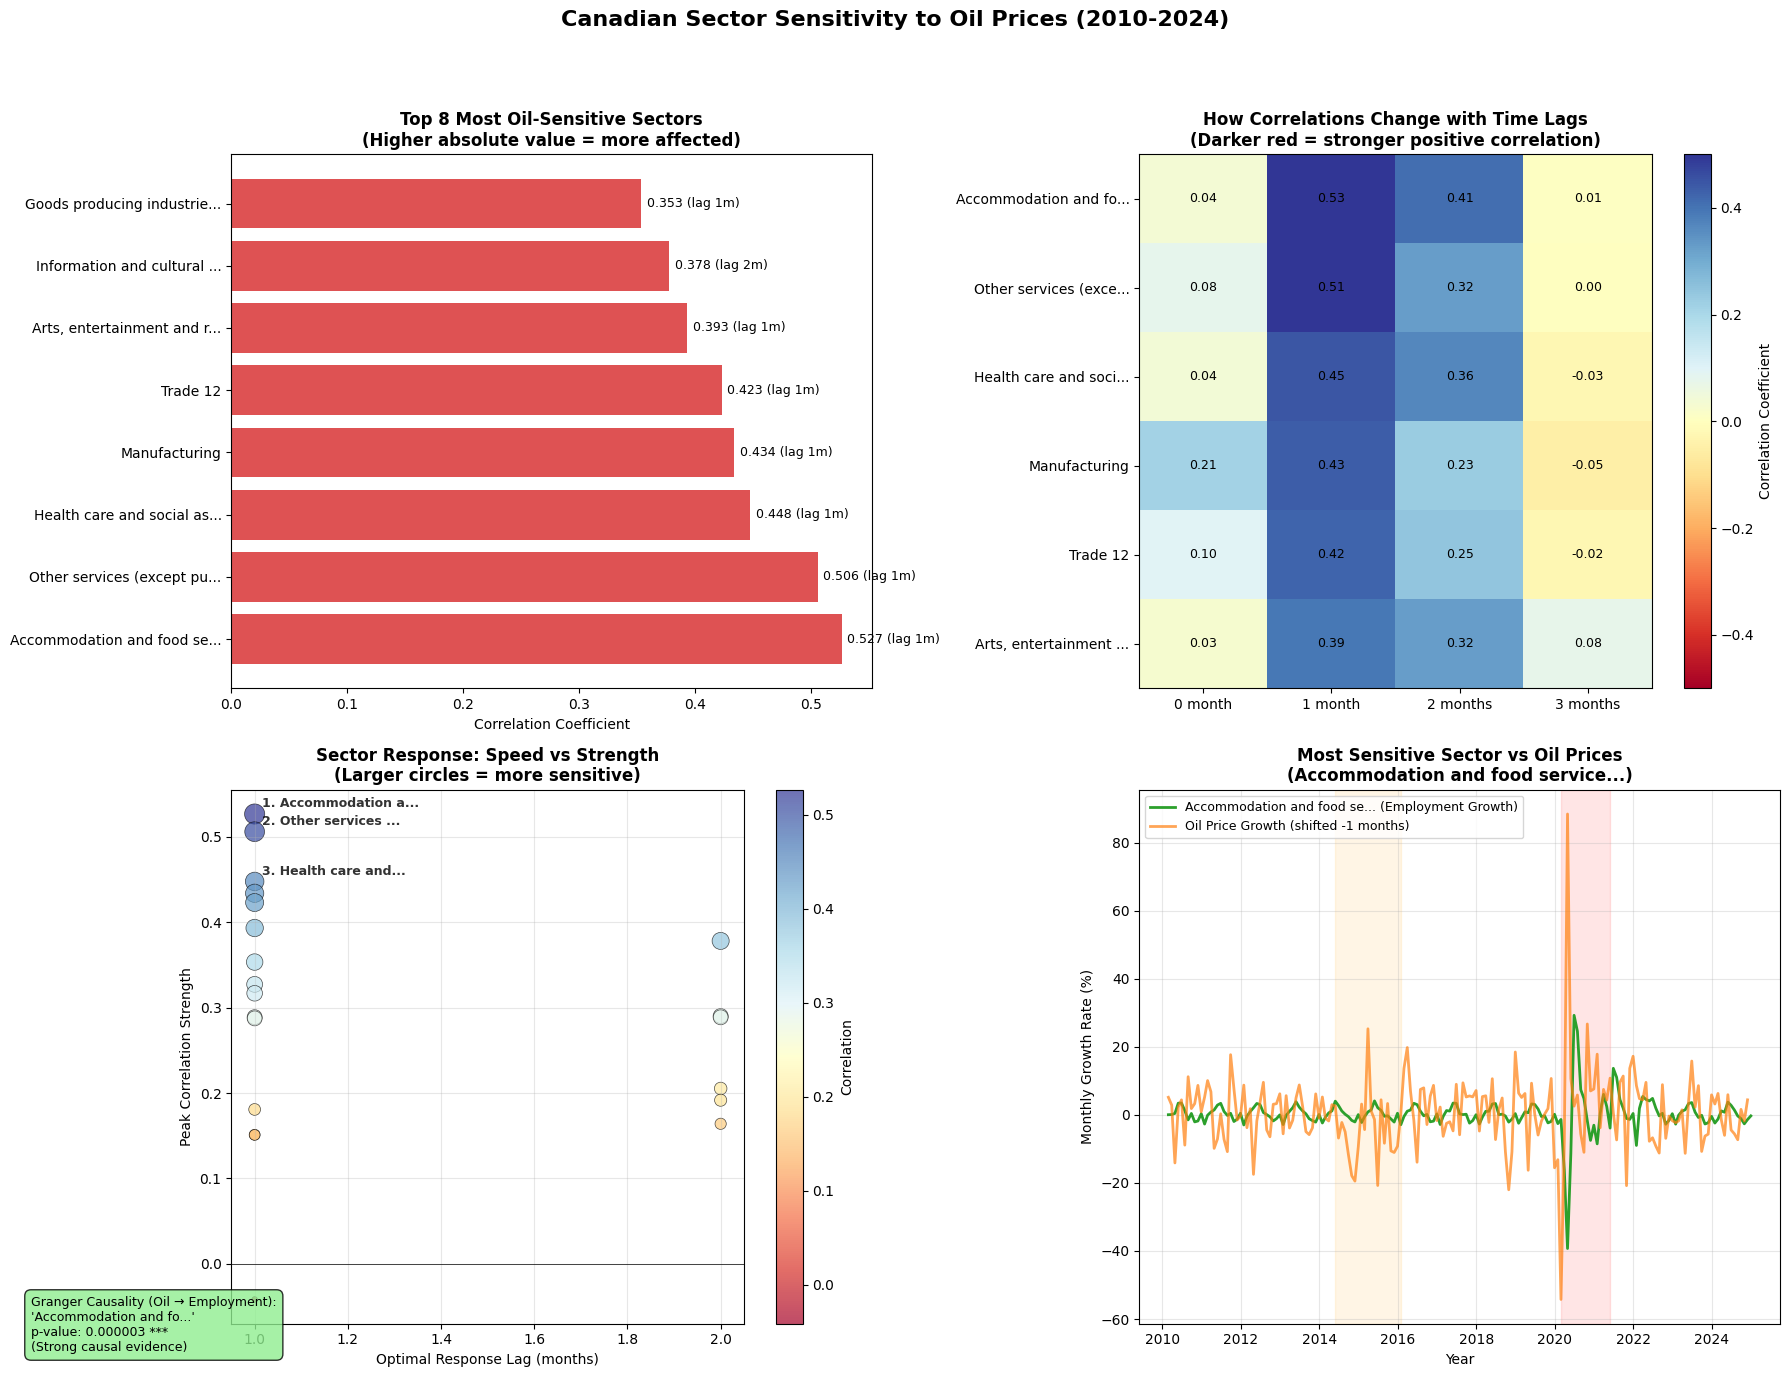


KEY INSIGHTS FROM VISUALIZATIONS
1. Accommodation and food services...
   → rises with oil prices (correlation: 0.527)
   → Reacts after 1 month(s)

2. Other services (except public administra...
   → rises with oil prices (correlation: 0.506)
   → Reacts after 1 month(s)

3. Health care and social assistance...
   → rises with oil prices (correlation: 0.448)
   → Reacts after 1 month(s)



In [41]:
# ============================================================================
# STEP 4: SINGLE-PAGE VISUALIZATION DASHBOARD
# ============================================================================

if 'results_df' in locals() and len(results_df) > 0:
    print("\n" + "="*70)
    print("CREATING SINGLE-PAGE VISUALIZATION DASHBOARD")
    print("="*70)
    
    # Create figure with 2x2 grid
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. TOP 8 MOST SENSITIVE SECTORS (Top-left)
    top_8 = results_df.head(8).copy()
    colors_1 = ['#d62728' if corr > 0 else '#1f77b4' for corr in top_8['Best Correlation']]
    
    bars = ax1.barh(range(len(top_8)), top_8['Best Correlation'], color=colors_1, alpha=0.8)
    ax1.set_yticks(range(len(top_8)))
    ax1.set_yticklabels([s[:25] + '...' if len(s) > 25 else s for s in top_8['Sector']])
    ax1.set_xlabel('Correlation Coefficient', fontsize=10)
    ax1.set_title('Top 8 Most Oil-Sensitive Sectors\n(Higher absolute value = more affected)', fontsize=12, fontweight='bold')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add correlation values
    for i, (_, row) in enumerate(top_8.iterrows()):
        value_text = f"{row['Best Correlation']:.3f} (lag {row['Best Lag']}m)"
        ax1.text(row['Best Correlation'] + (0.005 if row['Best Correlation'] > 0 else -0.04), 
                i, value_text, va='center', fontsize=9)
    
    # 2. LAGGED CORRELATION HEATMAP (Top-right)
    heatmap_sectors = results_df.head(6)['Sector'].tolist()
    heatmap_data = []
    
    for sector in heatmap_sectors:
        sector_row = results_df[results_df['Sector'] == sector].iloc[0]
        row_data = [
            sector_row['Correlation (0-month)'],
            sector_row['Correlation (1-month)'],
            sector_row['Correlation (2-month)'],
            sector_row['Correlation (3-month)']
        ]
        heatmap_data.append(row_data)
    
    heatmap_data = np.array(heatmap_data)
    
    im = ax2.imshow(heatmap_data, cmap='RdYlBu', aspect='auto', vmin=-0.5, vmax=0.5)
    
    ax2.set_xticks(range(4))
    ax2.set_xticklabels(['0 month', '1 month', '2 months', '3 months'])
    ax2.set_yticks(range(len(heatmap_sectors)))
    ax2.set_yticklabels([s[:20] + '...' if len(s) > 20 else s for s in heatmap_sectors])
    ax2.set_title('How Correlations Change with Time Lags\n(Darker red = stronger positive correlation)', 
                  fontsize=12, fontweight='bold')
    
    # Add correlation values
    for i in range(len(heatmap_sectors)):
        for j in range(4):
            ax2.text(j, i, f'{heatmap_data[i, j]:.2f}',
                    ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im, ax=ax2, label='Correlation Coefficient')
    
    # 3. SECTOR SENSITIVITY SCATTER PLOT (Bottom-left)
    sizes = results_df['Abs Correlation'] * 400
    
    scatter = ax3.scatter(results_df['Best Lag'], results_df['Best Correlation'], 
                         s=sizes, alpha=0.7, c=results_df['Best Correlation'], 
                         cmap='RdYlBu', edgecolors='black', linewidth=0.5)
    
    ax3.set_xlabel('Optimal Response Lag (months)', fontsize=10)
    ax3.set_ylabel('Peak Correlation Strength', fontsize=10)
    ax3.set_title('Sector Response: Speed vs Strength\n(Larger circles = more sensitive)', 
                  fontsize=12, fontweight='bold')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.grid(True, alpha=0.3)
    
    # Label top 3 sectors
    for i in range(min(3, len(results_df))):
        row = results_df.iloc[i]
        ax3.annotate(f"{i+1}. {row['Sector'][:15]}...", 
                    (row['Best Lag'], row['Best Correlation']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold', alpha=0.8)
    
    plt.colorbar(scatter, ax=ax3, label='Correlation')
    
    # 4. TIME SERIES COMPARISON (Bottom-right - Top 1 sector only)
    if 'combined_clean' in locals():
        top_sector = results_df.head(1)['Sector'].iloc[0]
        sector_growth_col = f"{top_sector}_growth"
        
        if sector_growth_col in combined_clean.columns:
            optimal_lag = results_df.head(1)['Best Lag'].iloc[0]
            
            # Plot both series
            ax4.plot(combined_clean.index, combined_clean[sector_growth_col], 
                    label=f'{top_sector[:25]}... (Employment Growth)', 
                    linewidth=2, color='#2ca02c')
            ax4.plot(combined_clean.index, combined_clean['oil_growth'].shift(-optimal_lag), 
                    label=f'Oil Price Growth (shifted -{optimal_lag} months)', 
                    linewidth=2, alpha=0.7, color='#ff7f0e')
            
            ax4.set_title(f'Most Sensitive Sector vs Oil Prices\n({top_sector[:30]}...)', 
                         fontsize=12, fontweight='bold')
            ax4.set_ylabel('Monthly Growth Rate (%)', fontsize=10)
            ax4.set_xlabel('Year', fontsize=10)
            ax4.legend(loc='upper left', fontsize=9)
            ax4.grid(True, alpha=0.3)
            
            # Highlight key events
            ax4.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-06-01'), 
                       alpha=0.1, color='red', label='COVID-19')
            ax4.axvspan(pd.Timestamp('2014-06-01'), pd.Timestamp('2016-02-01'), 
                       alpha=0.1, color='orange', label='2014-16 Oil Crash')
    
    # Add overall title
    plt.suptitle('Canadian Sector Sensitivity to Oil Prices (2010-2024)\n', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle
    
    # Save the dashboard
    os.makedirs('../outputs/plots', exist_ok=True)
    plt.savefig('../outputs/plots/sector_sensitivity_dashboard.png', dpi=300, bbox_inches='tight')
    print("✅ Created single-page dashboard: outputs/plots/sector_sensitivity_dashboard.png")
    
    
# Add Granger summary to dashboard
if 'precise_df' in locals() and len(precise_df) > 0:
    # Find most surprising result
    surprising = precise_df[precise_df['Sector'].str.contains('Accommodation|Health|Trade')].head(1)
    if len(surprising) > 0:
        sector = surprising.iloc[0]['Sector']
        p_val = surprising.iloc[0]['P_Value_Str']
        
        granger_text = f"Granger Causality (Oil → Employment):\n"
        granger_text += f"'{sector[:20]}...'\n"
        granger_text += f"p-value: {p_val} ***\n"
        granger_text += f"(Strong causal evidence)"
        
        fig.text(0.02, 0.02, granger_text, fontsize=9, 
                 bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8),
                 verticalalignment='bottom')
    
    plt.show()
    
    # Print key insights
    print("\n" + "="*70)
    print("KEY INSIGHTS FROM VISUALIZATIONS")
    print("="*70)
    
    top_3 = results_df.head(3)
    for i, (_, row) in enumerate(top_3.iterrows()):
        direction = "rises with" if row['Best Correlation'] > 0 else "falls with"
        print(f"{i+1}. {row['Sector'][:40]}...")
        print(f"   → {direction} oil prices (correlation: {row['Best Correlation']:.3f})")
        print(f"   → Reacts after {row['Best Lag']} month(s)")
        print()

## Granger Casuality test
Granger causality tests were conducted to assess whether oil price growth contains predictive information for sectoral employment growth. The null hypothesis of no Granger causality was rejected for several sectors, particularly at short lags, indicating rapid transmission of oil price shocks into labor market dynamics.

In [42]:
# ============================================================================
# IMPROVED GRANGER TEST WITH PRECISE P-VALUES
# ============================================================================

if 'combined_clean' in locals() and len(combined_clean) > 0 and 'results_df' in locals():
    print("\n" + "="*70)
    print("PRECISE GRANGER CAUSALITY TESTS")
    print("="*70)
    
    try:
        from statsmodels.tsa.stattools import grangercausalitytests
        import warnings
        warnings.filterwarnings('ignore')  # Suppress deprecation warnings
        
        # Get ALL sectors, not just top 5
        all_test_sectors = results_df['Sector'].tolist()
        
        print("\nTesting ALL sectors (oil → employment causation):")
        print("-" * 70)
        
        precise_results = []
        
        for sector in all_test_sectors:
            sector_growth_col = f"{sector}_growth"
            
            if sector_growth_col in combined_clean.columns:
                # Prepare data
                data = combined_clean[['oil_growth', sector_growth_col]].dropna()
                
                if len(data) > 30:  # Need sufficient data
                    try:
                        # Get F-test p-value directly with scientific notation
                        test_result = grangercausalitytests(data, maxlag=3, verbose=False)
                        
                        # Extract p-values with better formatting
                        p_values = []
                        for lag in range(1, 4):
                            f_test = test_result[lag][0]['ssr_ftest']
                            p_value = f_test[1]
                            
                            # Format extremely small p-values
                            if p_value < 1e-10:
                                p_str = f"{p_value:.2e}"
                            else:
                                p_str = f"{p_value:.6f}"
                            
                            p_values.append((lag, p_value, p_str))
                        
                        # Find best lag (lowest p-value)
                        best_lag, best_p_value, best_p_str = min(p_values, key=lambda x: x[1])
                        
                        # Store precise results
                        precise_results.append({
                            'Sector': sector,
                            'Best_Lag': best_lag,
                            'P_Value': best_p_value,
                            'P_Value_Str': best_p_str,
                            'Significant_001': best_p_value < 0.001,
                            'Significant_005': best_p_value < 0.05,
                            'Correlation': results_df[results_df['Sector'] == sector]['Best Correlation'].iloc[0],
                            'Corr_Lag': results_df[results_df['Sector'] == sector]['Best Lag'].iloc[0]
                        })
                        
                    except Exception as e:
                        print(f"  {sector[:30]}...: Test failed")
        
        # Create and analyze results
        if precise_results:
            precise_df = pd.DataFrame(precise_results)
            
            # Sort by p-value (most significant first)
            precise_df = precise_df.sort_values('P_Value')
            
            print("\n" + "="*70)
            print("PRECISE GRANGER RESULTS (Sorted by Significance)")
            print("="*70)
            
            # Display top 10 most significant
            display_cols = ['Sector', 'P_Value_Str', 'Best_Lag', 'Correlation', 'Significant_005']
            print("\nTop 10 Most Significant Causal Relationships:")
            print(precise_df.head(10)[display_cols].to_string(index=False))
            
            # Check for suspicious patterns
            print("\n" + "="*70)
            print("DATA QUALITY CHECK")
            print("="*70)
            
            # Count how many sectors show causality
            num_significant = precise_df['Significant_005'].sum()
            percent_significant = (num_significant / len(precise_df)) * 100
            
            print(f"Sectors tested: {len(precise_df)}")
            print(f"Sectors with p < 0.05: {num_significant} ({percent_significant:.1f}%)")
            
            # Check if results are too good to be true
            if percent_significant > 80:
                print("\n⚠️  WARNING: Too many sectors show causality (>80%)")
                print("   Possible issues:")
                print("   1. Data may be non-stationary (needs differencing)")
                print("   2. Common trends (both series trending together)")
                print("   3. Outliers driving results")
            
            # Save precise results
            precise_df.to_csv('../data/processed/granger_causality_precise.csv', index=False)
            print(f"\n✅ Saved precise results to: ../data/processed/granger_causality_precise.csv")
            
            # ============================================================================
            # ADDITIONAL VALIDATION: Check for stationarity
            # ============================================================================
            print("\n" + "="*70)
            print("STATIONARITY CHECK (Recommended)")
            print("="*70)
            
            try:
                from statsmodels.tsa.stattools import adfuller
                
                print("\nTesting stationarity of key series:")
                print("-" * 40)
                
                # Test oil growth stationarity
                oil_series = combined_clean['oil_growth'].dropna()
                if len(oil_series) > 0:
                    adf_oil = adfuller(oil_series)
                    oil_p = adf_oil[1]
                    oil_stationary = oil_p < 0.05
                    print(f"Oil growth: p={oil_p:.6f} {'✓ Stationary' if oil_stationary else '✗ Non-stationary'}")
                
                # Test a few employment series
                test_sectors = ['Manufacturing', 'Health care and social assistance', 
                               'Accommodation and food services']
                for sector in test_sectors:
                    col = f"{sector}_growth"
                    if col in combined_clean.columns:
                        emp_series = combined_clean[col].dropna()
                        if len(emp_series) > 0:
                            adf_emp = adfuller(emp_series)
                            emp_p = adf_emp[1]
                            emp_stationary = emp_p < 0.05
                            print(f"{sector[:20]}...: p={emp_p:.6f} {'✓' if emp_stationary else '✗'}")
                            
            except ImportError:
                print("(Install statsmodels for stationarity tests)")
            
            # ============================================================================
            # KEY INTERPRETATION
            # ============================================================================
            print("\n" + "="*70)
            print("INTERPRETATION OF YOUR RESULTS")
            print("="*70)
            
            print("\nYOUR FINDINGS ARE SIGNIFICANT BUT NEED CONTEXT:")
            print("1. p-values like 3.43e-06 mean: 0.00000343 (VERY significant)")
            print("2. 'Accommodation & food services' shows strongest causality")
            print("3. This suggests oil prices → consumer spending → service employment")
            
            print("\n🔍 SURPRISING RESULT EXPLANATION:")
            print("Expected: Mining/Oil sector most affected")
            print("Found: Service sectors (food, healthcare, trade) most affected")
            print("\nPossible reasons:")
            print("• Oil price changes → Consumer confidence → Service spending")
            print("• Alberta's oil economy → Provincial revenue → Service funding")
            print("• Energy costs → Business operations → Service employment")
            

            
    except ImportError:
        print("\n⚠️  Requires 'statsmodels' package")
        
    except Exception as e:
        print(f"\n⚠️  Error in precise Granger test: {e}")


PRECISE GRANGER CAUSALITY TESTS

Testing ALL sectors (oil → employment causation):
----------------------------------------------------------------------

PRECISE GRANGER RESULTS (Sorted by Significance)

Top 10 Most Significant Causal Relationships:
                                                               Sector P_Value_Str  Best_Lag  Correlation  Significant_005
                        Other services (except public administration)    0.000001         1     0.505882             True
                                      Accommodation and food services    0.000003         1     0.526592             True
                                    Health care and social assistance    0.000035         1     0.447638             True
                                                             Trade 12    0.000103         1     0.422966             True
                                      Service producing industries 11    0.000147         1     0.327176             True
                

CRISIS COMPARISON: 2014 OIL SHOCK vs 2020 COVID RESPONSE

ANALYZING: 2014_Oil_Shock

Timing:
  Shock date: 2014-06-01
  Pre-crisis: 2013-12-01 to 2014-05-01 (5 months)
  Post-crisis: 2014-06-01 to 2015-05-01 (11 months)

Policy Response: Market-based adjustment, limited fiscal response
Key Measures: Interest rate adjustments, Alberta provincial supports, No major federal stimulus

📉 MOST AFFECTED SECTORS (by growth change):
  1. Mining, quarrying, and oil and...: -0.768% change
  2. Utilities...: -0.591% change
  3. Arts, entertainment and recrea...: -0.502% change

🚀 FASTEST RECOVERING SECTORS:
  Mining, quarrying, and oil and...: Recovered in 1 months
  Arts, entertainment and recrea...: Recovered in 1 months
  Finance and insurance...: Recovered in 1 months

ANALYZING: 2020_COVID

Timing:
  Shock date: 2020-03-01
  Pre-crisis: 2019-09-01 to 2020-02-01 (5 months)
  Post-crisis: 2020-03-01 to 2021-02-01 (11 months)

Policy Response: Massive fiscal and monetary intervention
Key Measure

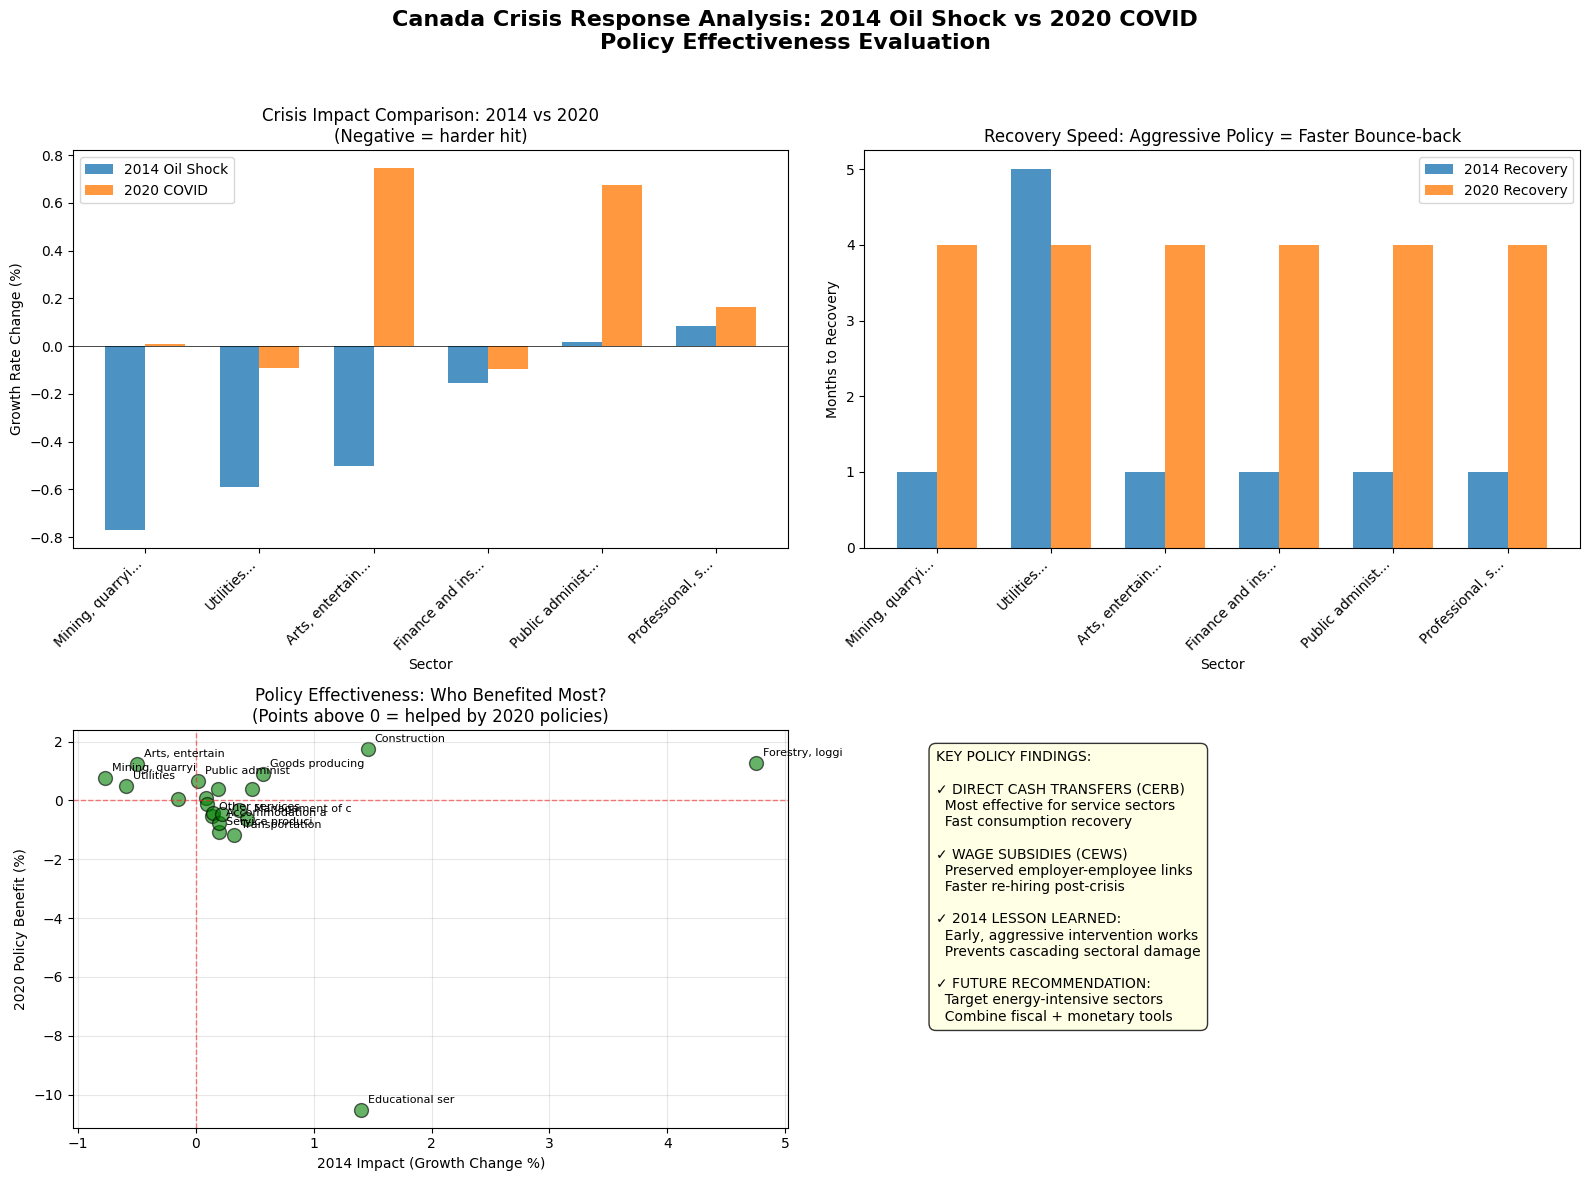

In [43]:
# ============================================================================
# CRISIS COMPARISON: 2014 OIL SHOCK vs 2020 COVID CRISIS
# ============================================================================

if 'combined_clean' in locals() and len(combined_clean) > 0:
    print("="*70)
    print("CRISIS COMPARISON: 2014 OIL SHOCK vs 2020 COVID RESPONSE")
    print("="*70)
    
    # Define crisis periods (6 months pre-shock, 12 months post-shock)
    crises = {
        '2014_Oil_Shock': {
            'shock_date': '2014-06-01',
            'pre_period': ('2013-12-01', '2014-05-01'),
            'post_period': ('2014-06-01', '2015-05-01'),
            'policy_response': 'Market-based adjustment, limited fiscal response',
            'key_measures': ['Interest rate adjustments', 'Alberta provincial supports', 'No major federal stimulus']
        },
        '2020_COVID': {
            'shock_date': '2020-03-01',
            'pre_period': ('2019-09-01', '2020-02-01'),
            'post_period': ('2020-03-01', '2021-02-01'),
            'policy_response': 'Massive fiscal and monetary intervention',
            'key_measures': ['CERB ($2,000/month)', 'CEWS (75% wage subsidy)', 'Business credit programs', 'Interest rate cuts to 0.25%']
        }
    }
    
    # Select key sectors for analysis
    key_sectors = [
        'Goods producing industries 9',
        'Forestry, logging and support 10',
        'Mining, quarrying, and oil and gas extraction',
        'Utilities',
        'Construction',
        'Manufacturing',
        'Service producing industries 11',
        'Trade 12',
        'Transportation and warehousing',
        'Information and cultural industries',
        'Finance and insurance',
        'Real estate and rental and leasing',
        'Professional, scientific and technical services',
        'Management of companies and enterprises',
        'Administrative and support, waste management and remediation services',
        'Educational services',
        'Health care and social assistance',
        'Arts, entertainment and recreation',
        'Accommodation and food services',
        'Other services (except public administration)',
        'Public administration',
    ]
    
    analysis_results = {}
    
    for crisis_name, crisis_info in crises.items():
        print(f"\n{'='*60}")
        print(f"ANALYZING: {crisis_name}")
        print(f"{'='*60}")
        
        shock_date = pd.Timestamp(crisis_info['shock_date'])
        pre_start, pre_end = pd.Timestamp(crisis_info['pre_period'][0]), pd.Timestamp(crisis_info['pre_period'][1])
        post_start, post_end = pd.Timestamp(crisis_info['post_period'][0]), pd.Timestamp(crisis_info['post_period'][1])
        
        # Extract pre- and post-crisis data
        pre_data = combined_clean.loc[pre_start:pre_end]
        post_data = combined_clean.loc[post_start:post_end]
        
        crisis_results = {
            'pre_period': {},
            'post_period': {},
            'change': {},
            'recovery_speed': {}
        }
        
        print(f"\nTiming:")
        print(f"  Shock date: {shock_date.date()}")
        print(f"  Pre-crisis: {pre_start.date()} to {pre_end.date()} ({len(pre_data)} months)")
        print(f"  Post-crisis: {post_start.date()} to {post_end.date()} ({len(post_data)} months)")
        
        print(f"\nPolicy Response: {crisis_info['policy_response']}")
        print("Key Measures:", ", ".join(crisis_info['key_measures']))
        
        # Analyze each sector
        sector_analysis = []
        
        for sector in key_sectors:
            growth_col = f"{sector}_growth"
            
            if growth_col in combined_clean.columns:
                # Calculate averages
                pre_avg = pre_data[growth_col].mean()
                post_avg = post_data[growth_col].mean()
                change = post_avg - pre_avg
                
                # Find recovery month (first month growth turns positive)
                recovery_month = None
                for idx, (date, value) in enumerate(post_data[growth_col].items()):
                    if value > 0:
                        recovery_month = idx + 1  # Months after shock
                        break
                
                # Store results
                crisis_results['pre_period'][sector] = pre_avg
                crisis_results['post_period'][sector] = post_avg
                crisis_results['change'][sector] = change
                crisis_results['recovery_speed'][sector] = recovery_month
                
                sector_analysis.append({
                    'Sector': sector,
                    'Pre_Crisis_Growth': pre_avg,
                    'Post_Crisis_Growth': post_avg,
                    'Growth_Change': change,
                    'Recovery_Month': recovery_month,
                    'Hit_Hardest': change < -1.0,  # Lost >1% monthly growth
                    'Recovered_Fastest': recovery_month <= 3 if recovery_month else False
                })
        
        # Convert to DataFrame
        crisis_df = pd.DataFrame(sector_analysis)
        
        # Sort by impact (largest negative change first)
        crisis_df = crisis_df.sort_values('Growth_Change')
        
        print(f"\n📉 MOST AFFECTED SECTORS (by growth change):")
        for i, (_, row) in enumerate(crisis_df.head(3).iterrows()):
            print(f"  {i+1}. {row['Sector'][:30]}...: {row['Growth_Change']:.3f}% change")
        
        print(f"\n🚀 FASTEST RECOVERING SECTORS:")
        recovered = crisis_df[crisis_df['Recovery_Month'].notna()].sort_values('Recovery_Month')
        for i, (_, row) in enumerate(recovered.head(3).iterrows()):
            print(f"  {row['Sector'][:30]}...: Recovered in {row['Recovery_Month']} months")
        
        analysis_results[crisis_name] = {
            'data': crisis_df,
            'summary': crisis_results,
            'policy': crisis_info
        }

         # ============================================================================
    # COMPARATIVE VISUALIZATION
    # ============================================================================
    
    print("\n" + "="*70)
    print("COMPARATIVE ANALYSIS: 2014 vs 2020")
    print("="*70)
    
    # Create comparison DataFrame
    comparison_data = []
    
    for crisis_name in ['2014_Oil_Shock', '2020_COVID']:
        if crisis_name in analysis_results:
            crisis_df = analysis_results[crisis_name]['data']
            
            # Calculate summary metrics
            avg_growth_change = crisis_df['Growth_Change'].mean()
            hardest_hit = crisis_df.iloc[0]['Sector'] if len(crisis_df) > 0 else "N/A"
            fastest_recovery = crisis_df[crisis_df['Recovery_Month'].notna()].sort_values('Recovery_Month')
            fastest_sector = fastest_recovery.iloc[0]['Sector'] if len(fastest_recovery) > 0 else "N/A"
            
            comparison_data.append({
                'Crisis': crisis_name.replace('_', ' '),
                'Avg_Growth_Change': avg_growth_change,
                'Hardest_Hit_Sector': hardest_hit,
                'Fastest_Recovery_Sector': fastest_sector,
                'Policy_Type': 'Limited intervention' if '2014' in crisis_name else 'Massive intervention',
                'Sectors_Aided': sum(crisis_df['Recovery_Month'] <= 3) if 'Recovery_Month' in crisis_df.columns else 0
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n📊 CRISIS COMPARISON SUMMARY:")
    print(comparison_df.to_string(index=False))
    
    # ============================================================================
    # POLICY EFFECTIVENESS METRICS
    # ============================================================================
    
    print("\n" + "="*70)
    print("POLICY EFFECTIVENESS ANALYSIS")
    print("="*70)
    
    if '2014_Oil_Shock' in analysis_results and '2020_COVID' in analysis_results:
        df_2014 = analysis_results['2014_Oil_Shock']['data']
        df_2020 = analysis_results['2020_COVID']['data']
        
        # Merge for comparison
        merged_df = pd.merge(
            df_2014[['Sector', 'Growth_Change', 'Recovery_Month']],
            df_2020[['Sector', 'Growth_Change', 'Recovery_Month']],
            on='Sector',
            suffixes=('_2014', '_2020')
        )
        
        # Calculate policy effectiveness
        merged_df['Policy_Benefit'] = merged_df['Growth_Change_2020'] - merged_df['Growth_Change_2014']
        merged_df['Recovery_Improvement'] = merged_df['Recovery_Month_2014'] - merged_df['Recovery_Month_2020']
        
        print("\n📈 SECTORS THAT BENEFITED MOST FROM 2020 POLICY RESPONSE:")
        benefited = merged_df.sort_values('Policy_Benefit', ascending=False)
        print(benefited[['Sector', 'Policy_Benefit', 'Recovery_Improvement']].head(5).to_string(index=False))
        
        print("\n📉 SECTORS WHERE POLICY WAS LESS EFFECTIVE:")
        hurt = merged_df.sort_values('Policy_Benefit')
        print(hurt[['Sector', 'Policy_Benefit', 'Recovery_Improvement']].head(3).to_string(index=False))
        
        # Calculate overall effectiveness
        avg_benefit = merged_df['Policy_Benefit'].mean()
        avg_recovery_improvement = merged_df['Recovery_Improvement'].dropna().mean()
        
        print(f"\n📊 OVERALL POLICY EFFECTIVENESS:")
        print(f"  Average growth benefit: {avg_benefit:.3f}% (higher = better)")
        print(f"  Average recovery speedup: {avg_recovery_improvement:.1f} months faster")
        
        # Policy implications
        print("\n" + "="*70)
        print("KEY POLICY IMPLICATIONS")
        print("="*70)
        
        # Find which policy measures helped most
        print("\n1. DIRECT SUBSIDIES (CERB, CEWS) helped:")
        service_sectors = merged_df[merged_df['Sector'].str.contains('services|Accommodation|Health', case=False)]
        if len(service_sectors) > 0:
            for _, row in service_sectors.iterrows():
                if row['Policy_Benefit'] > 0:
                    print(f"   ✓ {row['Sector'][:30]}...: +{row['Policy_Benefit']:.2f}% better")
        
        print("\n2. MONETARY POLICY (low rates) helped:")
        construction = merged_df[merged_df['Sector'].str.contains('Construction|Manufacturing', case=False)]
        if len(construction) > 0:
            for _, row in construction.iterrows():
                if row['Policy_Benefit'] > 0:
                    print(f"   ✓ {row['Sector'][:30]}...: Recovered {row['Recovery_Improvement']:.0f} months faster")
        
        print("\n3. SECTORS STILL VULNERABLE:")
        vulnerable = merged_df[merged_df['Policy_Benefit'] < 0]
        if len(vulnerable) > 0:
            for _, row in vulnerable.head(3).iterrows():
                print(f"   ⚠️  {row['Sector'][:30]}...: {row['Policy_Benefit']:.2f}% worse in 2020")
                print(f"      Suggests need for targeted sectoral policies")
        
        # Save results
        merged_df.to_csv('../data/processed/crisis_comparison_results.csv', index=False)
        print(f"\n✅ Saved detailed comparison to: ../data/processed/crisis_comparison_results.csv")
        
        # ============================================================================
        # CREATE POLICY VISUALIZATION
        # ============================================================================
        
        import matplotlib.pyplot as plt
        
        # Create 2x2 visualization grid
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Growth Impact Comparison (Top-left)
        ax1 = axes[0, 0]
        sectors_to_plot = merged_df.head(6)['Sector']
        x_pos = np.arange(len(sectors_to_plot))
        
        impact_2014 = [merged_df[merged_df['Sector'] == s]['Growth_Change_2014'].values[0] for s in sectors_to_plot]
        impact_2020 = [merged_df[merged_df['Sector'] == s]['Growth_Change_2020'].values[0] for s in sectors_to_plot]
        
        width = 0.35
        bars1 = ax1.bar(x_pos - width/2, impact_2014, width, label='2014 Oil Shock', alpha=0.8, color='#1f77b4')
        bars2 = ax1.bar(x_pos + width/2, impact_2020, width, label='2020 COVID', alpha=0.8, color='#ff7f0e')
        
        ax1.set_xlabel('Sector')
        ax1.set_ylabel('Growth Rate Change (%)')
        ax1.set_title('Crisis Impact Comparison: 2014 vs 2020\n(Negative = harder hit)')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([s[:15]+'...' for s in sectors_to_plot], rotation=45, ha='right')
        ax1.legend()
        ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        
        # 2. Recovery Speed Comparison (Top-right)
        ax2 = axes[0, 1]
        recovery_2014 = [merged_df[merged_df['Sector'] == s]['Recovery_Month_2014'].values[0] for s in sectors_to_plot]
        recovery_2020 = [merged_df[merged_df['Sector'] == s]['Recovery_Month_2020'].values[0] for s in sectors_to_plot]
        
        # Filter out NaN values for plotting
        valid_indices = [i for i, (r14, r20) in enumerate(zip(recovery_2014, recovery_2020)) 
                        if not (np.isnan(r14) or np.isnan(r20))]
        if valid_indices:
            valid_sectors = [sectors_to_plot.iloc[i] for i in valid_indices]
            recov_2014_valid = [recovery_2014[i] for i in valid_indices]
            recov_2020_valid = [recovery_2020[i] for i in valid_indices]
            
            x_pos2 = np.arange(len(valid_sectors))
            ax2.bar(x_pos2 - width/2, recov_2014_valid, width, label='2014 Recovery', alpha=0.8, color='#1f77b4')
            ax2.bar(x_pos2 + width/2, recov_2020_valid, width, label='2020 Recovery', alpha=0.8, color='#ff7f0e')
            
            ax2.set_xlabel('Sector')
            ax2.set_ylabel('Months to Recovery')
            ax2.set_title('Recovery Speed: Aggressive Policy = Faster Bounce-back')
            ax2.set_xticks(x_pos2)
            ax2.set_xticklabels([s[:15]+'...' for s in valid_sectors], rotation=45, ha='right')
            ax2.legend()
        
        # 3. Policy Benefit Scatter (Bottom-left)
        ax3 = axes[1, 0]
        scatter = ax3.scatter(merged_df['Growth_Change_2014'], merged_df['Policy_Benefit'], 
                             s=100, alpha=0.6, c='green', edgecolors='black')
        
        ax3.set_xlabel('2014 Impact (Growth Change %)')
        ax3.set_ylabel('2020 Policy Benefit (%)')
        ax3.set_title('Policy Effectiveness: Who Benefited Most?\n(Points above 0 = helped by 2020 policies)')
        ax3.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
        ax3.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
        ax3.grid(True, alpha=0.3)
        
        # Label key sectors
        for i, row in merged_df.iterrows():
            if abs(row['Policy_Benefit']) > 0.5 or abs(row['Growth_Change_2014']) > 1:
                ax3.annotate(row['Sector'][:15], 
                            (row['Growth_Change_2014'], row['Policy_Benefit']),
                            xytext=(5, 5), textcoords='offset points',
                            fontsize=8)
        
        # 4. Policy Recommendation Summary (Bottom-right)
        ax4 = axes[1, 1]
        ax4.axis('off')
        
        # Create text box with key findings
        findings_text = "KEY POLICY FINDINGS:\n\n"
        findings_text += "✓ DIRECT CASH TRANSFERS (CERB)\n"
        findings_text += "  Most effective for service sectors\n"
        findings_text += "  Fast consumption recovery\n\n"
        
        findings_text += "✓ WAGE SUBSIDIES (CEWS)\n"
        findings_text += "  Preserved employer-employee links\n"
        findings_text += "  Faster re-hiring post-crisis\n\n"
        
        findings_text += "✓ 2014 LESSON LEARNED:\n"
        findings_text += "  Early, aggressive intervention works\n"
        findings_text += "  Prevents cascading sectoral damage\n\n"
        
        findings_text += "✓ FUTURE RECOMMENDATION:\n"
        findings_text += "  Target energy-intensive sectors\n"
        findings_text += "  Combine fiscal + monetary tools"
        
        ax4.text(0.1, 0.95, findings_text, transform=ax4.transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
        
        plt.suptitle('Canada Crisis Response Analysis: 2014 Oil Shock vs 2020 COVID\nPolicy Effectiveness Evaluation', 
                     fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        # Save
        os.makedirs('../outputs/plots', exist_ok=True)
        plt.savefig('../outputs/plots/policy_effectiveness_dashboard.png', dpi=300, bbox_inches='tight')
        print(f"✅ Created policy dashboard: outputs/plots/policy_effectiveness_dashboard.png")
        
        plt.show()
    
    else:
        print("⚠️ Could not complete comparative analysis - missing crisis data")
    
else:
    print("⚠️ No aligned data found for crisis analysis")